In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import patches
import scipy.sparse
import random
%matplotlib inline
np.set_printoptions(precision = 4)

In [2]:
Ph300 = scipy.io.loadmat('Ph300.mat')
Ph500 = scipy.io.loadmat('Ph500.mat')

ph300 = np.asarray(scipy.sparse.csc_matrix.todense(Ph300['Ph300']))
ph500 = np.asarray(scipy.sparse.csc_matrix.todense(Ph500['Ph500']))

### Funkcija koja iz vektora permutacije generira matricu permutacija

In [3]:
def permmat(vektor):
    n = vektor.size
    mat = np.zeros((n,n))
    for i in range(n):
        mat[i][vektor[i]] = 1
    return mat

### Funkcija $\mathbb{1}$-norme

In [4]:
def norma(B):
    n = max(B.shape)
    if(n == 0):
        return 0
    suma = np.sum(B);
    return suma/n

### Funkcija korak

Funkcija koja provjeri je li daljnja dekompozicija moguća, prima podmatricu B i threshold te vraća odgovarajuću podjelu, zajedno s flagom je li podjela moguća ili ne.

In [5]:
def korak(B, thr):
    u,s,v = np.linalg.svd(B)
    if(u.shape[1] == 1):
        return np.array([[1]]), 1, 0, 1
    vektor = u[:,1]
    
    n1 = sum(vektor <= 0)
    n2 = sum(vektor > 0)
    
    n = n1+n2

    P = permmat(np.argsort(vektor))
    Bnew = P @ B @ np.transpose(P)
    
    if(norma(Bnew[0:n1,0:n1]) > thr and norma(Bnew[n1:n,n1:n]) > thr):
        return P, n1, n2, 0
    else:
        return P, n1, n2, 1

### Glavna funkcija
Prvo provjerimo možemo li raditi daljnju bisekciju, ako ne možemo, vratimo što imamo, ako možemo, rekurzivno podijelimo podmatrice

In [6]:
def SVDmetastable(B, thr):
    n = max(B.shape)
    blokovi = []
    permutacija = np.eye(n)
    
    P, n1, n2, flag = korak(B, thr)
    
    if(flag == 1):
        #Ne možemo dalje rastavljat
        blokovi.insert(0,n)
        return blokovi, permutacija
    else:
        permutacija = P@permutacija
        B = P @ B @ np.transpose(P)
        
        blok1, perm1 = SVDmetastable(B[0:n1,0:n1], thr)
        blok2, perm2 = SVDmetastable(B[n1:n,n1:n], thr)
        
        pomp = np.zeros((n,n))
        pomp[0:n1, 0:n1] = perm1
        pomp[n1:n, n1:n] = perm2
        
        permutacija = pomp @ permutacija
        blokovi = blok1 + blok2
        
        return blokovi, permutacija

## Primjeri

[47, 20, 42, 24, 36, 46, 40]


Text(0.5, 1.0, 'Poslije algoritma, thr = 0.5')

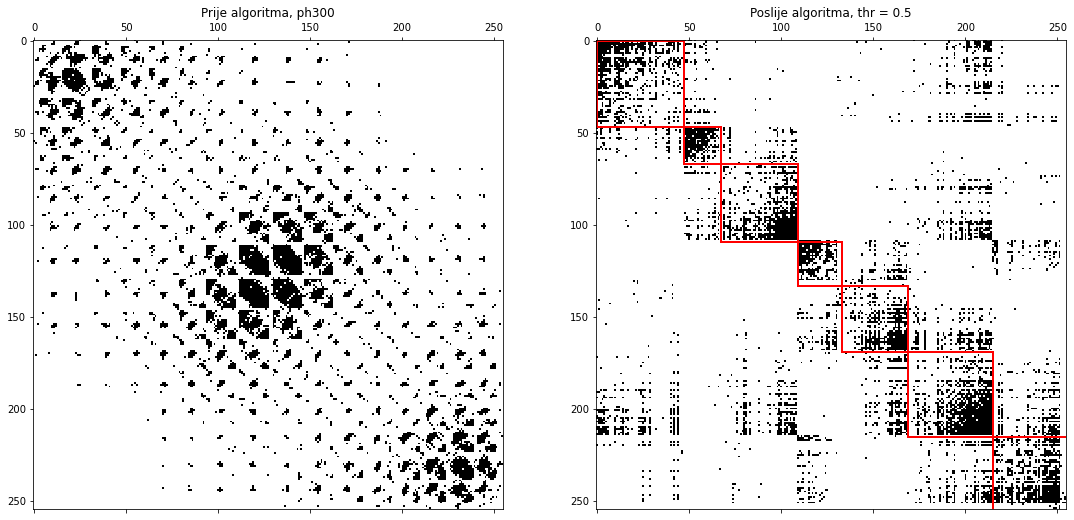

In [7]:
thr = .5

blokovi, P = SVDmetastable(ph300,thr)

ph = P @ ph300 @ np.transpose(P)

m = len(blokovi)
print(blokovi)
pozicije = (np.cumsum(blokovi))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax1.spy(ph300)
ax1.set_title("Prije algoritma, ph300")
ax2.spy(ph)
for i in range(m):
    d = blokovi[i]
    poz = pozicije[i]
    rect = patches.Rectangle((poz, poz), -d, -d, linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
ax2.set_title("Poslije algoritma, thr = 0.5")

[71, 88, 37, 51, 60]


Text(0.5, 1.0, 'Poslije algoritma, thr = 0.5')

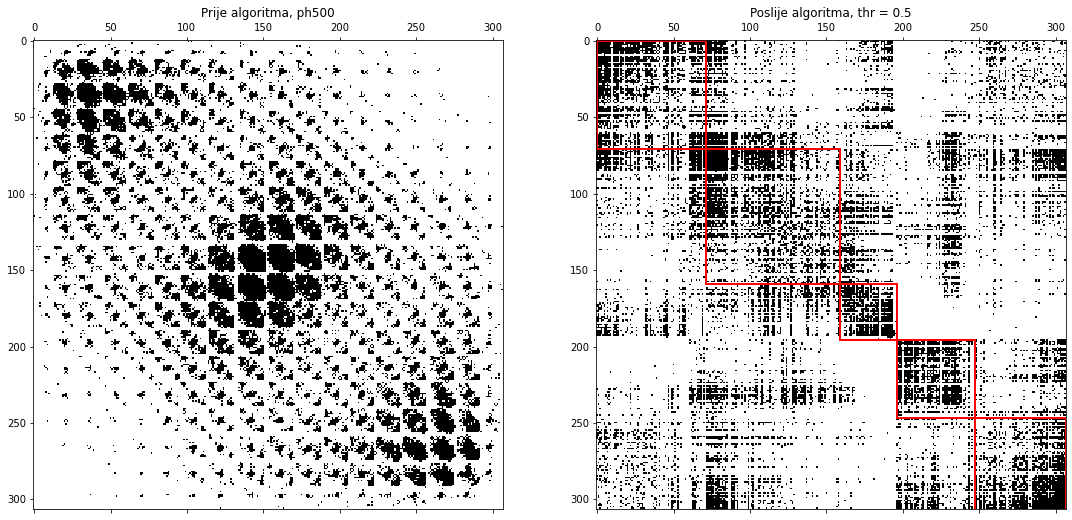

In [8]:
thr = .5

blokovi, P = SVDmetastable(ph500,thr)

ph = P @ ph500 @ np.transpose(P)

m = len(blokovi)
print(blokovi)

pozicije = (np.cumsum(blokovi))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax1.spy(ph500)
ax1.set_title("Prije algoritma, ph500")
ax2.spy(ph)
for i in range(m):
    d = blokovi[i]
    poz = pozicije[i]
    rect = patches.Rectangle((poz, poz), -d, -d, linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
ax2.set_title("Poslije algoritma, thr = 0.5")

### Generirani primjeri

Funkcija za generiranje perturbirane blok-stohastičke matrice

In [9]:
def generator2(lista,eps):
    n = sum(lista)
    broj = len(lista)
    x=0
    matrica=np.zeros((n,n))
    for i in range(0,broj):
        for j in range(0,lista[i]):
            for k in range(0,lista[i]):
                matrica[x+j][k+x]=random.uniform(0, 1)

        x+=lista[i]
        
    for i in range(n):
        suma=0
        for j in range(n):
            suma+=matrica[i][j]
        for j in range(n):
            matrica[i][j]=matrica[i][j]/suma
   
    for i in range(n):
        for j in range(n):
            if(matrica[i][j]==0):
                matrica[i][j]=random.uniform(0,eps)
                
    for i in range(n):
        suma=0
        for j in range(n):
            suma+=matrica[i][j]
        for j in range(n):
            matrica[i][j]=matrica[i][j]/suma      
    
    for i in range(n):
        suma=0
        for j in range(n):
            suma+=matrica[i][j]
    
    return matrica

Blokovi:  [40, 50, 30]


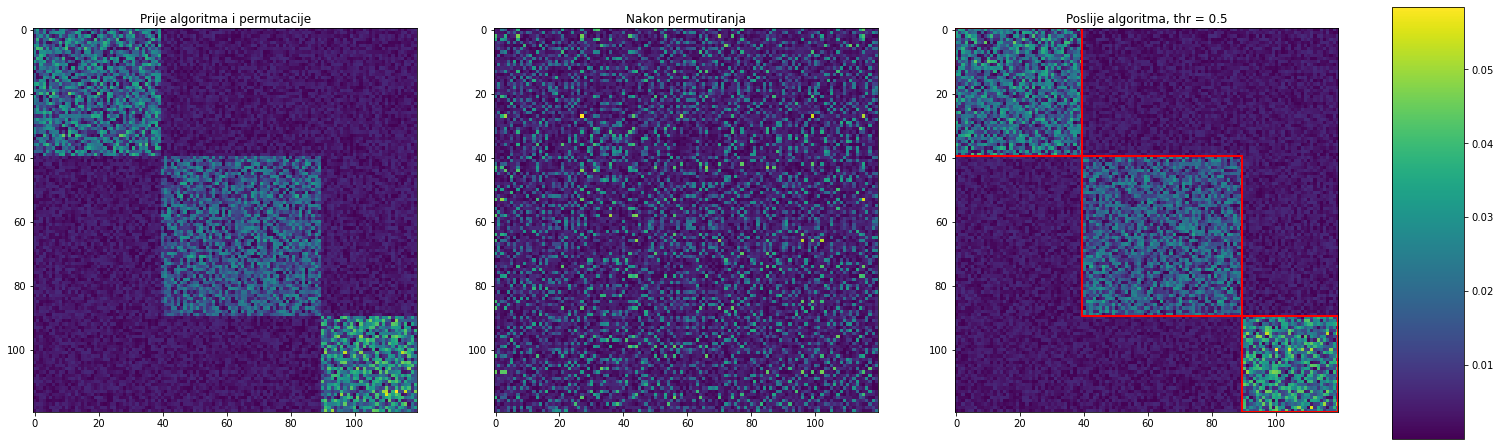

In [10]:
velicine = [40,50,30]
eps = 1e-2

A = generator2(velicine, eps)

randP = permmat(np.random.permutation(sum(velicine)))

permA = randP @ A @ np.transpose(randP)

blokovi, P = SVDmetastable(permA,.5)

print("Blokovi: ", blokovi)

ph = P @ permA @ np.transpose(P)

m = len(blokovi)

pozicije = (np.cumsum(blokovi))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(25, 15)
ax1.imshow(A)
ax1.set_title("Prije algoritma i permutacije")
ax2.imshow(permA)
ax2.set_title("Nakon permutiranja")
im = ax3.imshow(ph)
for i in range(m):
    d = blokovi[i]
    poz = pozicije[i]
    rect = patches.Rectangle((poz-0.5, poz-0.5), -d, -d, linewidth=2, edgecolor='r', facecolor='none')
    ax3.add_patch(rect)
ax3.set_title("Poslije algoritma, thr = 0.5")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.04, 0.4])
fig.colorbar(im, cax=cbar_ax)

Blokovi (thr = .3):  [19, 141]
Blokovi (thr = .7):  [160]


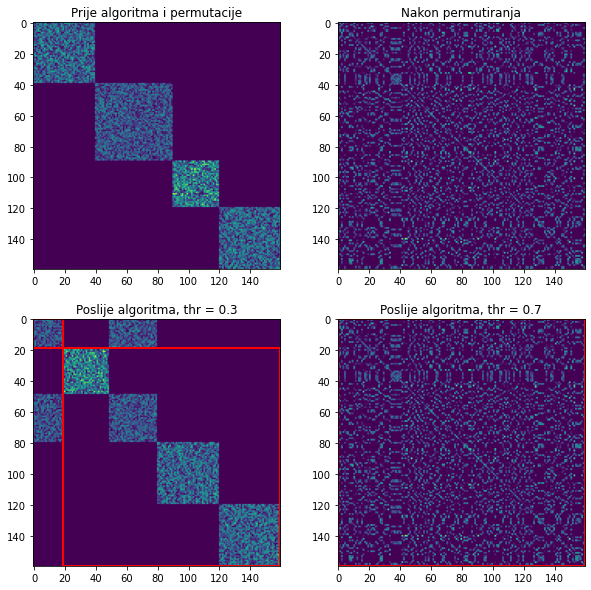

In [11]:
velicine = [40,50,30, 40]
#velicine = 25*[20] + np.random.randint(2, size = 25) #za generiranje primjera kada algoritam neće raditi
eps = 0

A = generator2(velicine, eps)

randP = permmat(np.random.permutation(sum(velicine)))

permA = randP @ A @ np.transpose(randP)

thr1 = .3
thr2 = .7

blokovi1, P1 = SVDmetastable(permA,thr1)
blokovi2, P2 = SVDmetastable(permA,thr2)

print("Blokovi (thr = .3): ", blokovi1)
print("Blokovi (thr = .7): ", blokovi2)

ph1 = P1 @ permA @ np.transpose(P1)
ph2 = P2 @ permA @ np.transpose(P2)

m1 = len(blokovi1)
pozicije1 = (np.cumsum(blokovi1))

m2 = len(blokovi2)
pozicije2 = (np.cumsum(blokovi2))

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10, 10)

axs[0,0].imshow(A)
axs[0,0].set_title("Prije algoritma i permutacije")

axs[0,1].imshow(permA)
axs[0,1].set_title("Nakon permutiranja")

axs[1,0].imshow(ph1)
axs[1,0].set_title("Poslije algoritma, thr = " + str(thr1))
for i in range(m1):
    d = blokovi1[i]
    poz = pozicije1[i]
    rect = patches.Rectangle((poz-0.5, poz-0.5), -d, -d, linewidth=2, edgecolor='r', facecolor='none')
    axs[1,0].add_patch(rect)
    
axs[1,1].imshow(ph2)
axs[1,1].set_title("Poslije algoritma, thr = " + str(thr2))
for i in range(m2):
    d = blokovi2[i]
    poz = pozicije2[i]
    rect = patches.Rectangle((poz-0.5, poz-0.5), -d, -d, linewidth=2, edgecolor='r', facecolor='none')
    axs[1,1].add_patch(rect)